# Add title here.

## Analysis setup

We begin by loading the Distributions and LowRankApprox Julia packages, as well as some function definitions used in the code chunks below.

In [3]:
using RCall
using LowRankApprox
using PyPlot
using Distributions

In [15]:
include("../code/julia/QPsubprob.jl");
include("../code/julia/ash.jl");
include("../code/julia/datasim.jl");
include("../code/julia/likelihood.jl");
include("../code/julia/mixSQP_time.jl");

In [3]:
# include("../code/julia/makedata.jl");
L = Array{Float64,2}(CSV.read("../data/sample100000x100.txt", nullable = false, header = false, delim = ' '));

In [6]:
QPsubprob(L, method = "mosek2")

Dict{String,Any} with 7 entries:
  "q_nnz"       => [4.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0,…
  "eachQPtime"  => [0.0076135, 0.00864415, 0.00725804, 0.00832327, 0.00718117, …
  "y_nnz"       => [4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 3.0, 2.0, 3.0,…
  "x"           => [0.496844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0…
  "linesearch"  => [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,…
  "totalQPtime" => 0.132389
  "numiter"     => 17

In [7]:
out = QPsubprob(L, method = "activeset")

Dict{String,Any} with 7 entries:
  "q_nnz"       => [4.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0,…
  "eachQPtime"  => [0.000759776, 0.000730392, 0.000733191, 0.000725747, 0.00068…
  "y_nnz"       => [4.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 3.0, 2.0, 3.0,…
  "x"           => [0.496844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0…
  "linesearch"  => [2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,…
  "totalQPtime" => 0.00977713
  "numiter"     => 17

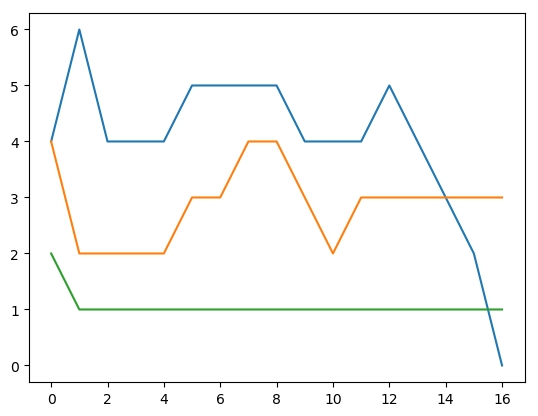

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13f515410>

In [48]:
plot(out["q_nnz"]); plot(out["y_nnz"]); plot(out["linesearch"])

In [16]:
srand(1)
x = [randn(5*10^3);3*randn(5*10^3)];
s = ones(10^4);
iter = 10;
mult = 4.^(0.6.^(1:iter));
m_range = zeros(iter); ip = zeros(iter); act = zeros(iter);
for i = 1:iter
    L = ash(x,s, mult = mult[i])[3];
    m_range[i] = size(L,2);
    ip[i] = mean(QPsubprob(L, method = "mosek2")["eachQPtime"]);
    act[i] = mean(QPsubprob(L, method = "activeset")["eachQPtime"]);
    println(i)
end

1
2
3
4
5
6
7
8
9
10


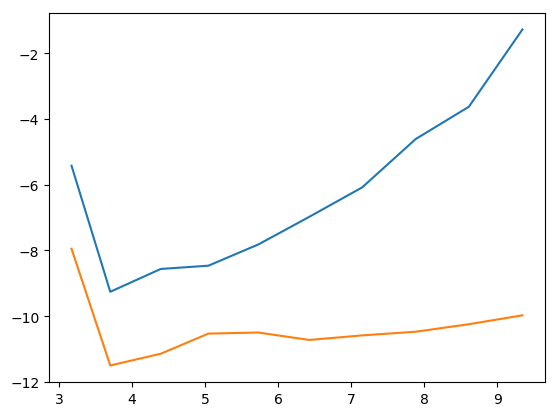

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10a583ad0>

In [17]:
plot(log2.(m_range),log2.(ip)); plot(log2.(m_range), log2.(act))

In [20]:
srand(1)
iter = 11;
Z = randn(5,10^5) .* [1;1;1;3;6];
z = Z[:]; s = ones(5*10^5);
n_range = 1000 * 2.^(1:iter);
m_range = zeros(iter); ip = zeros(iter); act = zeros(iter); r = zeros(iter);
for i = 1:iter
    n = n_range[i];
    x = normtmixdatasim(n);
    sd = autoselectmixsd(x,nv = 40);
    L  = normlikmatrix(x,sd = sd);
    r[i] = rank(L);
    ip[i] = mean(QPsubprob(L, method = "mosek2")["eachQPtime"]);
    act[i] = mean(QPsubprob(L, method = "activeset")["eachQPtime"]);
    println(i)
end

1
2
3
4
5
6
7
8
9
10
11


In [21]:
[n_range m_range ip act r]

11×5 Array{Float64,2}:
   2000.0      0.0  0.00375166  0.000279451  15.0
   4000.0      0.0  0.00303997  0.000577921  18.0
   8000.0      0.0  0.00347959  0.000700127  19.0
  16000.0      0.0  0.00352255  0.000642592  19.0
  32000.0      0.0  0.00355213  0.000707255  20.0
  64000.0      0.0  0.00344347  0.000942685  20.0
 128000.0      0.0  0.00365203  0.00086356   23.0
 256000.0      0.0  0.00364132  0.000886949  22.0
 512000.0      0.0  0.00343551  0.000875116  24.0
      1.024e6  0.0  0.0035925   0.000818327  23.0
      2.048e6  0.0  0.00367949  0.000876095  23.0

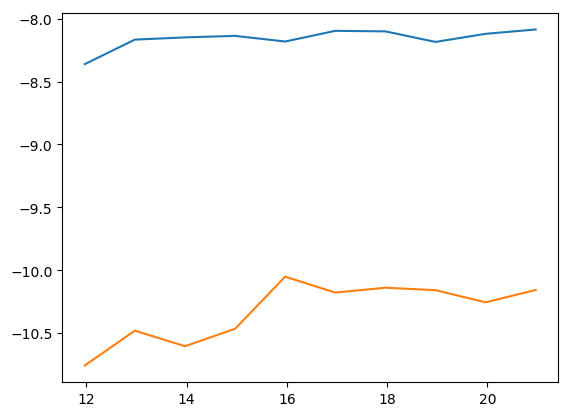

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13958a690>

In [22]:
plot(log2.(n_range[2:end]),log2.(ip[2:end])); plot(log2.(n_range[2:end]), log2.(act[2:end]))

In [47]:
n = 100
A = Diagonal(rand(n)) * 3;
B = zeros(n+1,n+1);
B[2:n+1,2:n+1] = A;
B[1,2:end] = -sum(A,1)
B[2:end,1] = -sum(A,2)
B[1,1] = sum(A)
B

101×101 Array{Float64,2}:
 146.862      -1.01333  -2.17152  -1.67857  …  -2.44315  -0.216803  -1.54302
  -1.01333     1.01333   0.0       0.0          0.0       0.0        0.0    
  -2.17152     0.0       2.17152   0.0          0.0       0.0        0.0    
  -1.67857     0.0       0.0       1.67857      0.0       0.0        0.0    
  -0.0465411   0.0       0.0       0.0          0.0       0.0        0.0    
  -0.295374    0.0       0.0       0.0      …   0.0       0.0        0.0    
  -2.48716     0.0       0.0       0.0          0.0       0.0        0.0    
  -2.91979     0.0       0.0       0.0          0.0       0.0        0.0    
  -1.32432     0.0       0.0       0.0          0.0       0.0        0.0    
  -1.13969     0.0       0.0       0.0          0.0       0.0        0.0    
  -0.644       0.0       0.0       0.0      …   0.0       0.0        0.0    
  -0.28796     0.0       0.0       0.0          0.0       0.0        0.0    
  -1.34805     0.0       0.0       0.0          0.

In [52]:
prod(eig(B)[1][2:end]), prod(diag(A))

(4997.6245491576365, 49.481431179781694)

In [49]:
eig(B)[1]

101-element Array{Float64,1}:
  -5.11142e-16
   0.0175394  
   0.026081   
   0.0469371  
   0.0509037  
   0.0827199  
   0.112063   
   0.133327   
   0.171542   
   0.218517   
   0.25306    
   0.26772    
   0.272547   
   ⋮          
   2.64685    
   2.70921    
   2.77486    
   2.81991    
   2.83574    
   2.88823    
   2.92531    
   2.93834    
   2.95212    
   2.96415    
   2.9923     
 148.859      